In [1]:
from data import get_data, get_processed_data
from train_test import train, output_to_accu, test
from helpers import plot_cm, count_parameters
from models import MLP, ConvNet, LSTM
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
from torch import nn
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import shap

from captum.attr import IntegratedGradients

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
_, target_prices, _, features = get_data()

input_period = 21
input_period_reg = 10
training_window = 10

X, _, y, _ = get_processed_data(features, target_prices, input_period, input_period_reg, training_window)

In [3]:
train_indices, test_indices, _, _ = train_test_split(range(len(y)), y, test_size=0.2, shuffle=False)
X_train, y_train, X_test, y_test = X[train_indices], y[train_indices], X[test_indices], y[test_indices]
print('Number of train sample :', len(X_train))
print('Number of test sample :', len(X_test))

X_mean = X_train.mean(dim=[0, 1], keepdim=True)
X_std = X_train.std(dim=[0, 1], keepdim=True)
X_train = X_train.sub_(X_mean).div_(X_std)
X_test = X_test.sub_(X_mean).div_(X_std)

Number of train sample : 2100
Number of test sample : 526


In [4]:
class_count_train = np.unique(y_train.cpu(), axis=0, return_counts=True)[1]
class_count_test = np.unique(y_test.cpu(), axis=0, return_counts=True)[1]
weights_train = torch.tensor(class_count_train / sum(class_count_train))
weights_test = torch.tensor(class_count_test / sum(class_count_test))
print('Allocation of best returns in train set :', weights_train.cpu().numpy())
print('Allocation of best returns in test set :', weights_test.cpu().numpy())

Allocation of best returns in train set : [0.508 0.492]
Allocation of best returns in test set : [0.487 0.513]


In [5]:
class MLP(nn.Module):
    def __init__(self, dim1, dim2, pdrop=0.1, hidden_size1=10, hidden_size2=10, hidden_size3=10):
        super().__init__()

        self.fc1 = nn.Linear(dim1 * dim2, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, 2)
        
        self.drop1 = nn.Dropout(pdrop)
        self.drop2 = nn.Dropout(pdrop)
        self.drop3 = nn.Dropout(pdrop)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu1(self.drop1(self.fc1(x)))
        x = self.relu2(self.drop2(self.fc2(x)))
        x = self.relu3(self.drop3(self.fc3(x)))
        x = self.softmax(self.fc4(x))       

        return x

In [6]:
class ConvNet(nn.Module):
    def __init__(self, dim1, dim2, pdrop=0.1, dim1_kernel1=10, dim2_kernel1=3, dim1_kernel2=5, dim2_kernel2=2):
        super().__init__()
        
        self.dim1 = dim1
        self.dim2 = dim2
        
        self.conv1 = nn.Conv2d(1, 5, kernel_size=(dim1_kernel1, dim2_kernel1))
        self.conv2 = nn.Conv2d(5, 10, kernel_size=(dim1_kernel2, dim2_kernel2))
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(10 * (dim1 - dim1_kernel1 - dim1_kernel2 + 2) * (dim2 - dim2_kernel1 - dim2_kernel2 + 2), 10)
        self.fc2 = nn.Linear(10, 2)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.softmax = nn.Softmax(dim=1)

        self.drop = nn.Dropout(pdrop)
        self.drop2d = nn.Dropout2d(pdrop)

    def forward(self, x):
        
        x = x.view(x.size(0), 1, x.size(1), x.size(2))
        x = self.relu1(self.drop2d(self.conv1(x)))
        x = self.relu2(self.drop2d(self.conv2(x)))
    
        x = x.flatten(start_dim=1)
        x = self.relu3(self.drop(self.fc1(x)))
        x = self.softmax(self.fc2(x))

        return x

In [7]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, device, hidden_size=10, num_layers=2, pdrop=0.1):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, output_size)

        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.lstm(x, (h0.detach(), c0.detach()))
        x = self.softmax(self.fc(x[:, -1, :]))

        return x

In [8]:
def shap_heatmap(model, X, X_test):
    
    explainer = shap.DeepExplainer(model, X)
    shap_values = explainer.shap_values(X_test)

    shap_matrix = np.mean(np.mean(shap_values, axis=0), axis=0).T
    shap_matrix = np.abs(shap_matrix)

    fig, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(data=shap_matrix, annot=False, cmap='Reds', cbar=False, 
                yticklabels=features.columns, xticklabels=list(reversed(- (np.arange(input_period) + 1))))

    ax.tick_params(axis='both', which='major', labelsize=8, labelleft=True, labeltop=True, labelbottom=False, rotation=0, length=0)

    plt.show()

In [9]:
eta = 1e-3
weight_decay = 1e-4
dropout = 0.1
batch_size = 30
nb_epochs = 100

verbose = 3

model_name = 'ConvNet'

dim1, dim2 = X.size(1), X.size(2)

model_MLP = MLP(dim1, dim2, pdrop=dropout)

model_ConvNet = ConvNet(dim1, dim2, pdrop=dropout)

model_LSTM = LSTM(input_size=dim2, output_size=y.size(1), device=device, pdrop=dropout)
    
train(model_MLP, X_train, y_train, nb_epochs=nb_epochs, device=device, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

train(model_ConvNet, X_train, y_train, nb_epochs=nb_epochs, device=device, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

train(model_LSTM, X_train, y_train, nb_epochs=nb_epochs, device=device, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


In [10]:
model_MLP.eval()
print(f' MLP Accuracy on train set : {output_to_accu(model_MLP, X_train, y_train):.2f} %')
print(f' MLP Accuracy on test set : {output_to_accu(model_MLP, X_test, y_test):.2f} %')

model_ConvNet.eval()
print(f' ConvNet Accuracy on train set : {output_to_accu(model_ConvNet, X_train, y_train):.2f} %')
print(f' ConvNet Accuracy on test set : {output_to_accu(model_ConvNet, X_test, y_test):.2f} %')

model_LSTM.eval()
print(f' LSTM Accuracy on train set : {output_to_accu(model_LSTM, X_train, y_train):.2f} %')
print(f' LSTM Accuracy on test set : {output_to_accu(model_LSTM, X_test, y_test):.2f} %')

 MLP Accuracy on train set : 96.48 %
 MLP Accuracy on test set : 47.15 %
 ConvNet Accuracy on train set : 96.24 %
 ConvNet Accuracy on test set : 49.81 %
 LSTM Accuracy on train set : 84.90 %
 LSTM Accuracy on test set : 50.57 %


In [11]:
# shap_heatmap(model_MLP, X_train, X_test)

In [12]:
# shap_heatmap(model_ConvNet, X_train, X_test)

In [13]:
def attr_heatmap(model, X_test):  
    ig = IntegratedGradients(model)

    attr1 = np.abs(ig.attribute(X_test, target=1, return_convergence_delta=False).detach().numpy())
    attr2 = np.abs(ig.attribute(X_test, target=1, return_convergence_delta=False).detach().numpy())
    attr = (attr1 + attr2) / 2

    attr_matrix = np.mean(attr, axis=0).T
    attr_matrix = np.abs(attr_matrix)

    fig, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(data=attr_matrix, annot=False, cmap='Reds', cbar=False, 
                yticklabels=features.columns, xticklabels=list(reversed(- (np.arange(input_period) + 1))))

    ax.tick_params(axis='both', which='major', labelsize=8, labelleft=True, labeltop=True, labelbottom=False, rotation=0, length=0)

    plt.show()

In [24]:
def attr_barplot(model, X_test):  
    ig = IntegratedGradients(model)

    attr1 = np.abs(ig.attribute(X_test, target=1, return_convergence_delta=False).detach().numpy())
    attr2 = np.abs(ig.attribute(X_test, target=1, return_convergence_delta=False).detach().numpy())
    attr = (attr1 + attr2) / 2

    attr_matrix = np.sum(np.mean(attr, axis=0), axis=0)
    attr_matrix = np.abs(attr_matrix)

    fig, ax = plt.subplots(figsize=(10,8))
    sns.barplot(y=features.columns, x=attr_matrix, color='r')

    plt.show()

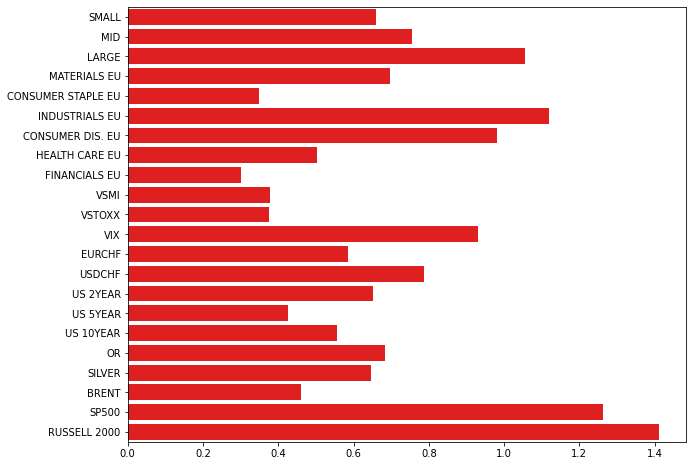

In [25]:
attr_barplot(model_MLP, X_test)

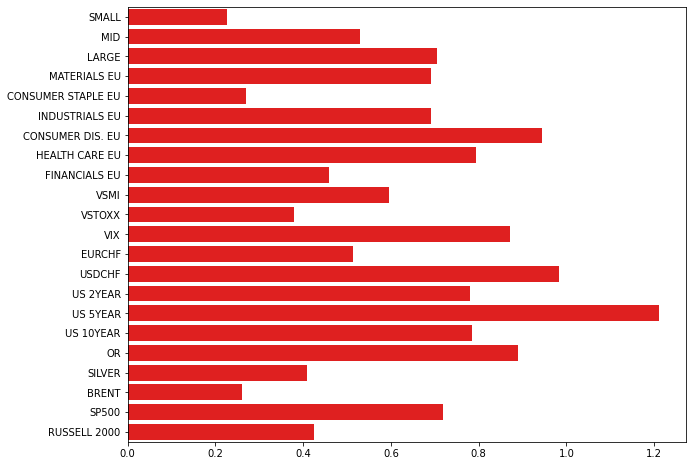

In [26]:
attr_barplot(model_ConvNet, X_test)

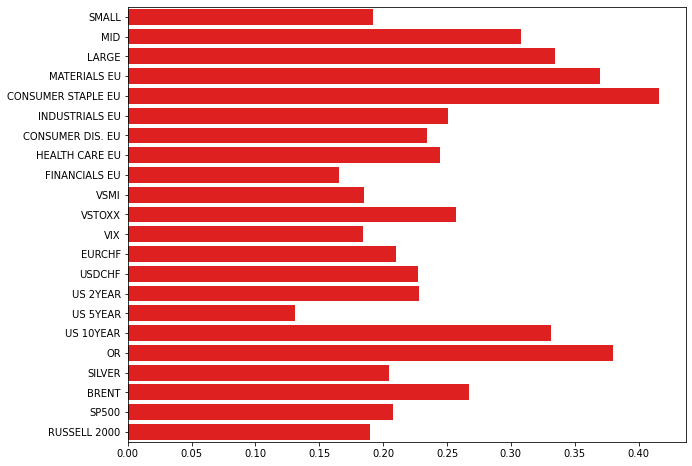

In [28]:
attr_barplot(model_LSTM, X_train)

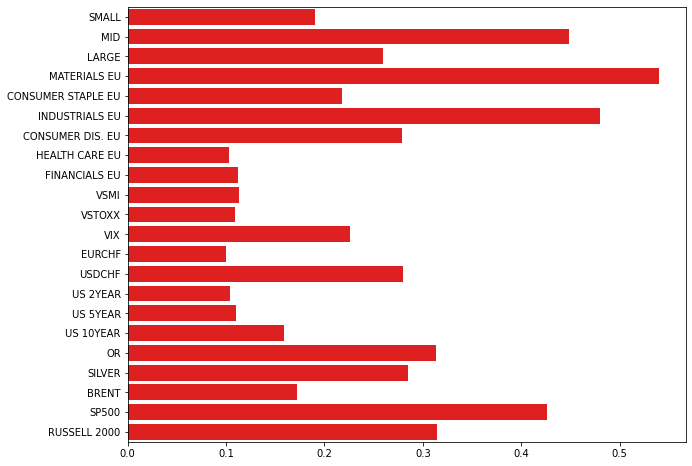

In [27]:
attr_barplot(model_LSTM, X_test)

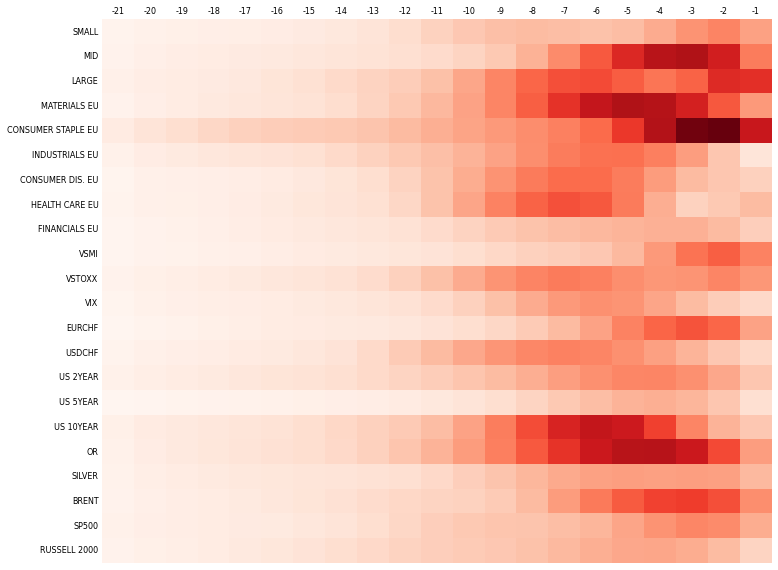

In [18]:
attr_heatmap(model_LSTM, X_train)

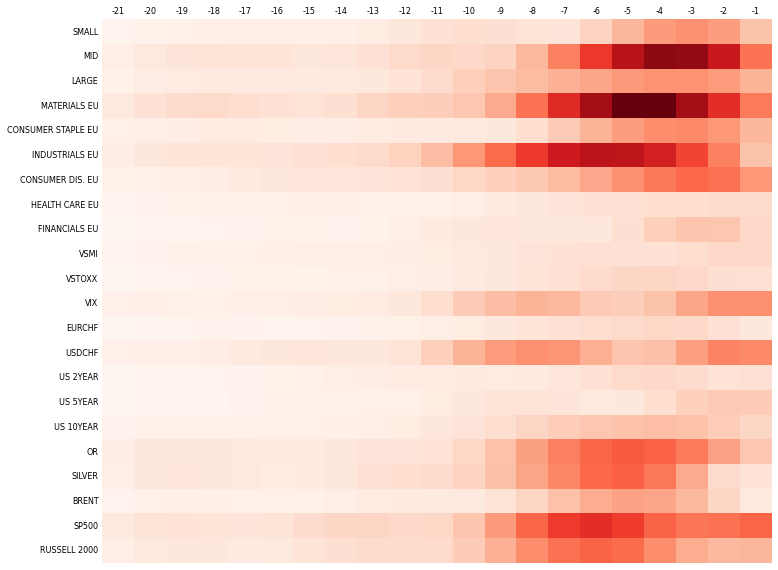

In [19]:
attr_heatmap(model_LSTM, X_test)